In [1]:
!unzip Equivariant_QCNN.zip

Archive:  Equivariant_QCNN.zip
   creating: Equivariant_QCNN/
   creating: Equivariant_QCNN/Result/
  inflating: Equivariant_QCNN/Result/.DS_Store  
   creating: Equivariant_QCNN/Result/Data/
  inflating: Equivariant_QCNN/Result/Data/.DS_Store  
  inflating: Equivariant_QCNN/Result/Data/.DS_StoreZone.Identifier  
   creating: Equivariant_QCNN/Result/Data/CNN/
  inflating: Equivariant_QCNN/Result/Data/CNN/CNN_result.py  
  inflating: Equivariant_QCNN/Result/Data/CNN/CNN_result.pyZone.Identifier  
   creating: Equivariant_QCNN/Result/Data/CNN/loss history/
  inflating: Equivariant_QCNN/Result/Data/CNN/loss history/result_CNN_FASHION_2L.txt  
  inflating: Equivariant_QCNN/Result/Data/CNN/loss history/result_CNN_FASHION_2L.txtZone.Identifier  
  inflating: Equivariant_QCNN/Result/Data/CNN/loss history/result_CNN_FASHION_2L_DATA2.txt  
  inflating: Equivariant_QCNN/Result/Data/CNN/loss history/result_CNN_FASHION_2L_DATA2.txtZone.Identifier  
  inflating: Equivariant_QCNN/Result/Data/CNN

In [2]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 121.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.4 MB/s eta 0:00:00


In [3]:
import sys
import os

# add the main directory to the notebook
sys.path.append(
    os.path.abspath(
        os.path.join("./")
    )
)

import numpy as np
# from Equivariant_QCNN.data.data import data_load_and_process
from Equivariant_QCNN.training.Training import circuit_training
from Equivariant_QCNN.models.QCNN_circuit import QCNN
import matplotlib.pyplot as plt
from Equivariant_QCNN.benchmarking.Benchmarking import (
    accuracy_test,
    round_predictions_f,
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
!unzip datasets_hd5.zip

Archive:  datasets_hd5.zip
  inflating: Electron-Photon-bilinear-tracker-(16, 16, 1).h5  
  inflating: QG-bilinear-tracker-(16, 16, 1).h5  


In [5]:


# Loads and Processes the data that will be used in QCNN and Hierarchical Classifier Training

import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
import h5py

def data_load_and_process(dataset, classes=[0, 1], feature_reduction= "img16x16x1", binary=True):

    if dataset == 'fashion_mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
        x_train, x_test = x_train[..., np.newaxis] / 255.0, x_test[..., np.newaxis] / 255.0  # normalize the data

    elif dataset == 'mnist':
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
        x_train, x_test = x_train[..., np.newaxis] / 255.0, x_test[..., np.newaxis] / 255.0  # normalize the data

    elif dataset == "quark_gluon":
        QG_path = "/content/QG-bilinear-tracker-(16, 16, 1).h5" ## quark_gluon-16x16-MMS.h5 solo tiene una clase
        with h5py.File(QG_path, "r") as file:
            X = np.array(file["X"])
            y = np.array(file["y"])

        X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=0.2,random_state=42, shuffle = True)

        X_train = X_train[:20000]
        Y_train = Y_train[:20000]
        X_test = X_test[:5000]
        Y_test = Y_test[:5000]

    elif dataset == "electron_photon":
        path_ep = "/content/Electron-Photon-bilinear-tracker-(16, 16, 1).h5"
        with h5py.File(path_ep, "r") as file:
            X_ep = np.array(file["X"])
            y_ep = np.array(file["y"])

        x_train, x_test, y_train, y_test = train_test_split(X_ep, y_ep, test_size=0.2, random_state=42, stratify=y_ep)
        X_train = x_train[:20000]
        Y_train = y_train[:20000]
        X_test = x_test[:5000]
        Y_test = y_test[:5000]

    else:
        print("No valid dataset. Please choose one of the following: mnist, fashion_mnist, quark_gluon or electron_photon.")

## classes
    if classes == 'odd_even':
        odd = [1, 3, 5, 7, 9]
        X_train = x_train
        X_test = x_test
        if binary == False:
            Y_train = [1 if y in odd else 0 for y in y_train]
            Y_test = [1 if y in odd else 0 for y in y_test]
        elif binary == True:
            Y_train = [1 if y in odd else -1 for y in y_train]
            Y_test = [1 if y in odd else -1 for y in y_test]

    elif classes == '>4':
        greater = [5, 6, 7, 8, 9]
        X_train = x_train
        X_test = x_test
        if binary == False:
            Y_train = [1 if y in greater else 0 for y in y_train]
            Y_test = [1 if y in greater else 0 for y in y_test]
        elif binary == True:
            Y_train = [1 if y in greater else -1 for y in y_train]
            Y_test = [1 if y in greater else -1 for y in y_test]

## processing
    else:
        if dataset == "quark_gluon" or "electron_photon":
            pass
        else:
            x_train_filter_01 = np.where((y_train == classes[0]) | (y_train == classes[1]))
            x_test_filter_01 = np.where((y_test == classes[0]) | (y_test == classes[1]))

            X_train, X_test = x_train[x_train_filter_01], x_test[x_test_filter_01]
            Y_train, Y_test = y_train[x_train_filter_01], y_test[x_test_filter_01]

    if binary == False:
        Y_train = [1 if y == classes[0] else 0 for y in Y_train]
        Y_test = [1 if y == classes[0] else 0 for y in Y_test]
    elif binary == True:
        Y_train = [1 if y == classes[0] else -1 for y in Y_train]
        Y_test = [1 if y == classes[0] else -1 for y in Y_test]

    if feature_reduction == 'img16x16x1':
        X_train = tf.image.resize(X_train[:], (16,16)).numpy()
        X_test = tf.image.resize(X_test[:], (16,16)).numpy()
        X_train = np.expand_dims(X_train, axis=-1)
        X_test = np.expand_dims(X_test, axis=-1)
        X_train = np.squeeze(X_train, axis=-1)
        X_test = np.squeeze(X_test, axis=-1)
        return X_train, X_test, Y_train, Y_test

    elif feature_reduction == 'resize256':
        X_train = tf.image.resize(X_train[:], (256, 1)).numpy()
        X_test = tf.image.resize(X_test[:], (256, 1)).numpy()
        X_train, X_test = tf.squeeze(X_train).numpy(), tf.squeeze(X_test).numpy()
        return X_train, X_test, Y_train, Y_test

    elif feature_reduction == 'pca8':
        X_train = tf.image.resize(X_train[:], (X_train.shape[1]*X_train.shape[1], 1)).numpy()
        X_test = tf.image.resize(X_test[:], (X_test.shape[1]*X_test.shape[1], 1)).numpy()
        X_train, X_test = tf.squeeze(X_train), tf.squeeze(X_test)

        pca = PCA(8)

        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

        # Rescale for angle embedding
        X_train, X_test = (X_train - X_train.min()) * (np.pi / (X_train.max() - X_train.min())),\
                              (X_test - X_test.min()) * (np.pi / (X_test.max() - X_test.min()))


        return X_train, X_test, Y_train, Y_test




In [7]:
"""
Here are possible combinations of benchmarking user could try.
Unitaries: ['U_TTN', 'U2_equiv', 'U4_equiv', 'U_5', 'U_6', 'U_9', 'U_13', 'U_14', 'U_15', 'U_SO4', 'U_SU4', 'U_SU4_no_pooling', 'U_SU4_1D', 'U_9_1D']
U_num_params: [2, 6, 6, 10, 10, 2, 6, 6, 4, 6, 15, 15, 15, 2]
feature_reduction: ['img16x16x1','resize256', 'pca8']
embedding_type: ["Equivariant-Amplitude", "Amplitude", "Angle"]
dataset: 'mnist' or 'fashion_mnist' or "quark_gluon"
circuit: 'QCNN'
cost_fn: 'mse' or 'cross_entropy'
Note: when using 'mse' as cost_fn binary="True" is recommended, when using 'cross_entropy' as cost_fn must be binary="False".
"""

# invariant testings

# U2_equiv is invariant under p4m using MSE
# U2_equiv is invariant under reflections over X using cross_entropy


params = np.random.random(200)
U_params = 6
U = "U2_equiv"
embedding_type = "Equivariant-Amplitude"
feature_reduction = "img16x16x1"
circuit = "QCNN"
cost_fn = "mse"
binary = True
dataset = "electron_photon"


X_train, X_test, Y_train, Y_test = data_load_and_process(
    dataset, classes=[0, 1], feature_reduction="img16x16x1", binary=True
)
X_train.shape
# 1 for quark, #-1 (0) for gluon
print(X_train.shape)

(20000, 16, 16, 1)


In [13]:
# Implementation of Quantum circuit training procedure
import sys
import os
import csv
import time
from datetime import datetime

# add the main directory to the notebook
sys.path.append(os.path.abspath(os.path.join('..')))


import Equivariant_QCNN.models.QCNN_circuit as QCNN_circuit
import pennylane as qml
from pennylane import numpy as np
import autograd.numpy as anp
from Equivariant_QCNN.benchmarking.Benchmarking import accuracy_test

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def cross_entropy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        c_entropy = l * (anp.log(p[l])) + (1 - l) * anp.log(1 - p[1 - l])
        loss = loss + c_entropy
    return -1 * loss

def cost(params, X, Y, U, U_params, embedding_type, circuit, cost_fn):
    if circuit == 'QCNN':
        predictions = [QCNN_circuit.QCNN(x, params, U, U_params, embedding_type, cost_fn=cost_fn) for x in X]

    if cost_fn == 'mse':
        loss = square_loss(Y, predictions)
    elif cost_fn == 'cross_entropy':
        loss = cross_entropy(Y, predictions)
    return loss


def circuit_training(X_train, Y_train, U, U_params, embedding_type, layers, circuit, cost_fn, params, opt_type="Adam", steps=50, initial_learning_rate=0.01, batch_size=128, decay_factor=0.5, decay_steps=10):
    opt_classes = {
        "Adam": qml.AdamOptimizer(stepsize=initial_learning_rate),
        "Nesterov": qml.NesterovMomentumOptimizer(stepsize=initial_learning_rate)
    }

    opt = opt_classes[opt_type]

    loss_history = []
    train_acc_history = []

    start_time = time.time()

    for it in range(steps):
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]

        params, cost_new = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, U, U_params, embedding_type, circuit, cost_fn), params)
        loss_history.append(cost_new)

        predictions = [QCNN_circuit.QCNN(x, params, U, U_params, embedding_type, cost_fn, layers) for x in X_train[batch_size:batch_size*5]]

        accuracy = accuracy_test(predictions, Y_train[batch_size:batch_size*5], cost_fn, cost_fn == "mse")
        train_acc_history.append(accuracy)

        if it % 1 == 0:
            print("iteration: ", it, " cost: ", cost_new, "train_accuracy:", accuracy)

        if (it + 1) % decay_steps == 0:
            learning_rate = initial_learning_rate * decay_factor
            opt_classes = {
                "Adam": qml.AdamOptimizer(stepsize=learning_rate),
                "Nesterov": qml.NesterovMomentumOptimizer(stepsize=learning_rate)
            }
            opt = opt_classes[opt_type]
            print(f"Learning rate reduced to: {learning_rate}")

    training_time = time.time() - start_time

    metrics = {
        'Optimizer': opt_type,
        'Learning_Rate': initial_learning_rate,
        'Batch_Size': batch_size,
        'Epochs': steps,
        'Loss_Function': cost_fn,
        'Training_Time': f"{training_time:.2f}",
        'Final_Train_Accuracy': f"{train_acc_history[-1]:.2f}"
    }

    return loss_history, train_acc_history, params, metrics


def run_quantum_circuit_experiment(params, U_params, U, embedding_type, feature_reduction, circuit, cost_fn, binary, dataset, opt_type="Adam", steps=50, initial_learning_rate=0.01, batch_size=128, decay_factor=0.5, decay_steps=10):
    # Load and process data
    X_train, X_test, Y_train, Y_test = data_load_and_process(
        dataset, classes=[0, 1], feature_reduction=feature_reduction, binary=binary
    )

    # Define layers (you might want to adjust this based on your specific requirements)
    layers = 2  # Assuming 2 layers, adjust as needed

    # Training
    loss_history, train_acc_history, updated_params, train_metrics = circuit_training(
        X_train, Y_train, U, U_params, embedding_type, layers, circuit, cost_fn,
        params, opt_type, steps, initial_learning_rate, batch_size, decay_factor, decay_steps
    )

    # Testing
    start_time = time.time()
    test_predictions = [QCNN_circuit.QCNN(x, updated_params, U, U_params, embedding_type, cost_fn, layers) for x in X_test]
    inference_time = time.time() - start_time

    test_accuracy = accuracy_test(test_predictions, Y_test, cost_fn, cost_fn == "mse")

    # Combine metrics
    metrics = {
        **train_metrics,
        'Inference_Time': f"{inference_time:.2f}",
        'Final_Test_Accuracy': f"{test_accuracy:.2f}",
        'Training_Subset_Size': f"{len(X_train)} samples",
        'U_params': U_params,
        'U': U,
        'Embedding_Type': embedding_type,
        'Feature_Reduction': feature_reduction,
        'Circuit': circuit,
        'Cost_Function': cost_fn,
        'Binary': binary,
        'Dataset': dataset
    }

    # Write metrics to CSV
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_filename = f'quantum_circuit_metrics_{dataset}_{timestamp}.csv'
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=metrics.keys())
        writer.writeheader()
        writer.writerow(metrics)

    print(f"Metrics have been saved to {csv_filename}")

    return loss_history, train_acc_history, updated_params, metrics

In [16]:

# Usage example with pre-defined variables:
params = np.random.random(200)
U_params = 6
U = "U2_equiv"
embedding_type = "Equivariant-Amplitude"
feature_reduction = "img16x16x1"
circuit = "QCNN"
cost_fn = "mse"
binary = True
dataset = "electron_photon"

loss_history, train_acc_history, final_params, metrics = run_quantum_circuit_experiment(
    params, U_params, U, embedding_type, feature_reduction, circuit, cost_fn, binary, dataset,
    opt_type="Adam", steps=10, initial_learning_rate=0.001, batch_size=128, decay_factor=0.5, decay_steps=10
)

print("Experiment completed. Final metrics:", metrics)

iteration:  0  cost:  0.9982996408878966 train_accuracy: 0.478515625
iteration:  1  cost:  1.0053429181791114 train_accuracy: 0.478515625
iteration:  2  cost:  0.9977320632452488 train_accuracy: 0.478515625
iteration:  3  cost:  1.0000867287654092 train_accuracy: 0.478515625
iteration:  4  cost:  1.000299680127725 train_accuracy: 0.4765625
iteration:  5  cost:  0.9995452126865604 train_accuracy: 0.4765625
iteration:  6  cost:  0.999373379135037 train_accuracy: 0.4765625
iteration:  7  cost:  1.0012324108794943 train_accuracy: 0.4765625
iteration:  8  cost:  0.9973366965002921 train_accuracy: 0.4765625
iteration:  9  cost:  1.0046655269018123 train_accuracy: 0.4765625
Learning rate reduced to: 0.0005
Metrics have been saved to quantum_circuit_metrics_electron_photon_20241019_163342.csv
Experiment completed. Final metrics: {'Optimizer': 'Adam', 'Learning_Rate': 0.001, 'Batch_Size': 128, 'Epochs': 10, 'Loss_Function': 'mse', 'Training_Time': '477.29', 'Final_Train_Accuracy': '0.48', 'Infe

In [17]:
n_qubits = 8
layers = 3
# data and transformed data
matrix = np.array(X_train[1])
matrix_reflected_y = np.fliplr(matrix)  # Image Reflected over Y-axis
matrix_reflected_x = np.flipud(matrix)  # Image Reflected over X-axis
matrix_rotated_90 = np.rot90(matrix)  # Image rotated 90 degrees

print(Y_train[1])
result1 = QCNN(matrix, trained_params, U, U_params, embedding_type, cost_fn, layers)
result2 = QCNN(
    matrix_reflected_y, trained_params, U, U_params, embedding_type, cost_fn, layers
)
result3 = QCNN(
    matrix_reflected_x, trained_params, U, U_params, embedding_type, cost_fn, layers
)
result4 = QCNN(
    matrix_rotated_90, trained_params, U, U_params, embedding_type, cost_fn, layers
)

print(f" Output with Probabilities for Original Image: {result1}")
print(f" Output with Probabilities for Image Reflected over Y-axis: {result2}")
print(f" Output with Probabilities for Image Reflected over X-axis: {result3}")
print(f" Output with Probabilities for Image Rotated 90 Degrees: {result4}")

plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.title("Original")
plt.imshow(matrix)
plt.axis("off")

plt.subplot(1, 4, 2)
plt.title("Reflected Y")
plt.imshow(matrix_reflected_y)
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("Reflected X")
plt.imshow(matrix_reflected_x)
plt.axis("off")

plt.subplot(1, 4, 4)
plt.title("Rotated 90°")
plt.imshow(matrix_rotated_90)
plt.axis("off")

plt.tight_layout()

plt.show()

1


NameError: name 'trained_params' is not defined

In [ ]:
predictions = [
    QCNN(x, trained_params, U, U_params, embedding_type, cost_fn, layers)
    for x in X_test[:1000]
]

accuracy = accuracy_test(predictions, Y_test[:1000], cost_fn, binary)
accuracy

0.518

In [18]:
round_predictions = round_predictions_f(predictions, cost_fn)

cm = confusion_matrix(Y_test[:1000], round_predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

NameError: name 'predictions' is not defined

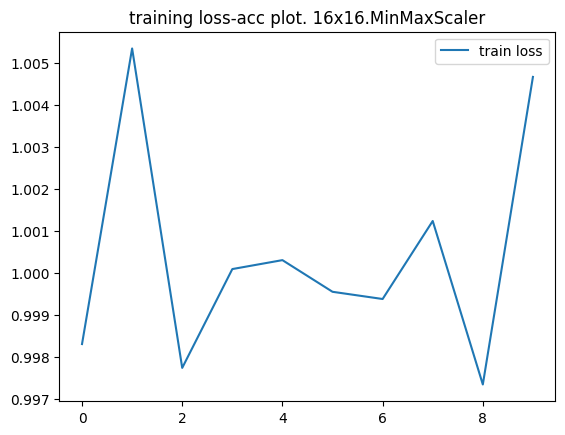

In [19]:
plt.plot(loss_history, label = "train loss")
plt.title("training loss-acc plot. 16x16.MinMaxScaler")
plt.yscale("linear")
plt.legend()
plt.show()